# Complete version

In [6]:
import numpy as np
import random
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
# "tabulate" is used to show Q-table in function "show_Q"

class fl:
    def __init__(self, grid, start, wins, lr, dr, eps, fails=None, hole_rate=None):
        # input
        self.rows = grid[0]
        self.cols = grid[1]
        self.start = start
        self.wins = wins
        self.fails = fails
        self.lr = lr
        self.dr = dr
        self.eps = eps
        self.hole_rate = hole_rate
        # learning outcomes
        self.Q = [[[0]*4 for j in range(self.rows)] for i in range(self.cols)]
        self.epi_values = [] # a list of average state-action values for line plot
        self.episodes = [] # a list of route lists for all episodes
        self.epi_num = 0 # the number of episodes
        self.win_num = 0 # the number of win episodes
        self.win_index = None # the first index of win episodes
        self.optimal_num = 0 # the number of optimal episodes
        self.optimal_step = None # the step number of the optimal episode
        self.optimal_route = [] # the route of the optimal episode
        self.optimal_index = None # the first index of optimal episodes
        self.epi_infos = [] # [epi_num, step_num, is_win]
        self.algo = None # "MC", "SS", or "QL"
    
    def get_grid(self):
        if self.fails != None:
            pass
        else:
            # generate random win-route and then randomly scatter holes
            too_long = True # path might cover more than (1-hole_rate) of the map
            state = self.start
            while too_long:
                is_end = False
                route = []
                route.append(self.start)
                while not is_end:
                    action = np.random.choice([0,1,2,3])
                    if action == 0:
                        state_ = (state[0] - 1, state[1])
                    elif action == 1:
                        state_ = (state[0] + 1, state[1])
                    elif action == 2:
                        state_ = (state[0], state[1] - 1)
                    else: # action == 3
                        state_ = (state[0], state[1] + 1)
                    if state_[0]<0 or state_[0]>self.rows-1 or state_[1]<0 or state_[1]>self.cols-1 or state == state_:
                        state_ = state
                    else:
                        route.append(state_)
                    state = state_
                    if state in self.wins:
                        is_end = True
                # cut the repeated nodes
                path_dic = {} # use dictionary to represent connectivity
                for i in range(len(route)-1):
                    path_dic[route[i]] = route[i+1] # note
                path = []
                key = self.start
                path.append(key)
                while True:
                    path.append(path_dic[key])
                    key = path_dic[key]
                    if key in self.wins:
                        break
                if len(path) < self.rows*self.cols*(1.0-self.hole_rate):
                    too_long = False
            blanks = []
            for i in range(self.rows):
                for j in range(self.cols):
                    if (i,j) not in path and (i,j) != self.start and (i,j) not in self.wins:
                        blanks.append((i,j))
            holes = []
            holes_index = np.random.choice(len(blanks), size=int(self.rows*self.cols*self.hole_rate), replace=False)
            for i in holes_index:
                holes.append(blanks[i])
            self.fails = holes
            
    def show_grid(self, state=None):
        if state == None:
            state = self.start
        for i in range(self.cols):
            print("-",end="")
        print("")
        for i in range(self.rows):
            for j in range(self.cols):
                if (i,j) in self.fails:
                    print("8", end="")
                elif (i,j) in self.wins:
                    print("1", end="")
                elif (i,j) == state:
                    print("*", end="")
                else:
                    print("O", end="")
            print("")
        for i in range(self.cols):
            print("-",end="")
        print("")
    
    def s2p(self, state):
        position = state[0]*self.cols+state[1]+1
        return position
    
    def choose_action(self, state):
        # find the index(es) with max value
        av = [] # action-value pair
        # find action(s) with maximum value(s) excluding Nones
        for (i,j) in enumerate(self.Q[state[0]][state[1]]):
            if j != None:
                av.append([i,j])
        max_value = max(j for [i,j] in av)
        max_indices = []
        for (i,j) in enumerate(self.Q[state[0]][state[1]]):
            if j == max_value:
                max_indices.append(i)
        # randomly select one action with max value
        max_index = random.choice(max_indices)
        # choose action with probabilities (ε-greedy)
        actions = []
        probs = []
        for [i,j] in av:
            if i == max_index:
                probs.append(1-self.eps+self.eps/len(av))
            else:
                probs.append(self.eps/len(av))
            actions.append(i)
        action = random.choices(actions, weights=probs, k=1)
        return action[0]
    
    def choose_max(self, state): # for QL
        # find the action with max value in the next state
        max_value = max(i for i in self.Q[state[0]][state[1]] if i != None)
        max_indices = []
        for (i,j) in enumerate(self.Q[state[0]][state[1]]):
            if j == max_value:
                max_indices.append(i)
        # randomly select one action with max value
        max_index = random.choice(max_indices)
        return max_index
    
    def take_action(self, state, action):
        # action: up(0) down(1) left(2) right(3)
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0] + 1, state[1])
        elif action == 2:
            next_state = (state[0], state[1] - 1)
        elif action == 3:
            next_state = (state[0], state[1] + 1)
        else:
            print("Wrong action.")
        if next_state[0]<0 or next_state[0]>self.rows-1 or next_state[1]<0 or next_state[1]>self.cols-1:
            next_state = state
            self.update_values(state, action, None)
        return next_state
    
    def update_values(self, state, action, value): # for TD algorithems
        self.Q[state[0]][state[1]][action] = value
    
    def get_reward(self, state):
        if state in self.wins:
            return 1
        elif state in self.fails:
            return -1
        else:
            return 0
        
    def get_value(self, state, action, reward, next_state, next_action): # for TD algorithems
        q0 = self.Q[state[0]][state[1]][action]
        q1 = self.Q[next_state[0]][next_state[1]][next_action]
        if q0 == None:
            return None
        else:
            q0_ = q0+self.lr*(reward+self.dr*q1-q0)
            return q0_
        
    def get_action_value(self, state, action):
        v = self.Q[state[0]][state[1]][action]
        if v == None:
            return 0
        else:
            return v
        
    def show_Q(self):
        row = self.rows*self.cols
        value = np.resize(self.Q,(row,4))
        table = [[]]*row
        for i in range(row):
            table[i].append(i+1)
            for j in range(len(value[i])):
                table[i].append(value[i][j])
        for i in range(len(table)):
            np.insert(table[i], 0, i+1)
        header = ["State","UP","DOWN","LEFT","RIGHT"]
        tab = np.resize(table,(row,5))
        print(tabulate(tab, headers=header))
    
    def MC(self, iteration):
        self.algo = "MC"
        for i in range(iteration):
            state = self.start
            is_end = False
            is_win = False
            step_num = 0
            sar = [] # [(state),action]
            episode = [self.s2p(state)]
            epi_value = []
            while not is_end:
                clear_output(wait=True)
                print("Episode:",self.epi_num)
                print("Step:",step_num)
                self.show_grid(state)
                step_num += 1
                action = self.choose_action(state) ########
                epi_value.append(self.get_action_value(state, action))
                next_state = self.take_action(state, action)
                next_action = self.choose_action(next_state)
                reward = self.get_reward(next_state)
                sar.append([state, action, reward])
                state = next_state
                episode.append(self.s2p(state))
                if state in self.wins or state in self.fails:
                    is_end = True
            if state in self.wins:
                is_win = True
                self.win_num += 1
                if self.win_index == None:
                    self.win_index = self.epi_num
                if self.optimal_step == None or step_num < self.optimal_step:
                    self.optimal_step = step_num
                    self.optimal_route = episode
                    self.optimal_num = 1
                    self.optimal_index = self.epi_num
                elif step_num == self.optimal_step:
                    self.optimal_num += 1
                else:
                    pass
            self.episodes.append(episode)
            self.epi_infos.append([self.epi_num, step_num, is_win])
            self.epi_num += 1
            self.epi_values.append(sum(epi_value)/len(epi_value))
            # update Q values
            for j in range(len(sar)):
                if j != 0:
                    sar[-j-1][2] += self.dr*sar[-j][2]
            returns = []
            visited = []
            for j in sar:
                if (j[0][0],j[0][1]) not in visited:
                    returns.append(j)
                visited.append((j[0][0],j[0][1]))
            for j in returns:
                if self.Q[j[0][0]][j[0][1]][j[1]] != None:
                    self.Q[j[0][0]][j[0][1]][j[1]] = (1-self.lr)*self.Q[j[0][0]][j[0][1]][j[1]]+self.lr*j[2]
        
    def SS(self, iteration):
        self.algo = "SS"
        for i in range(iteration):
            state = self.start
            is_end = False
            is_win = False
            step_num = 0
            action = self.choose_action(state)
            episode = [self.s2p(state)]
            epi_value = []
            while not is_end:
                clear_output(wait=True)
                print("Episode:",self.epi_num)
                print("Step:",step_num)
                self.show_grid(state)
                step_num += 1
                next_state = self.take_action(state, action)
                reward = self.get_reward(next_state)
                next_action = self.choose_action(next_state)
                value = self.get_value(state, action, reward, next_state, next_action)
                epi_value.append(self.get_action_value(state, action))
                self.update_values(state, action, value)
                last_action = action
                action = next_action
                state = next_state
                episode.append(self.s2p(state))
                if state in self.wins or state in self.fails:
                    is_end = True
            if state in self.wins:
                is_win = True
                self.win_num += 1
                if self.win_index == None:
                    self.win_index = self.epi_num
                if self.optimal_step == None or step_num < self.optimal_step:
                    self.optimal_step = step_num
                    self.optimal_route = episode
                    self.optimal_num = 1
                    self.optimal_index = self.epi_num
                elif step_num == self.optimal_step:
                    self.optimal_num += 1
                else:
                    pass
            self.episodes.append(episode)
            self.epi_infos.append([self.epi_num, step_num, is_win])
            self.epi_num += 1
            self.epi_values.append(sum(epi_value)/len(epi_value))
        
    def QL(self, iteration):
        self.algo = "QL"
        for i in range(iteration):
            state = self.start
            is_end = False
            is_win = False
            step_num = 0
            action = self.choose_action(state)
            episode = [self.s2p(state)]
            epi_value = []
            while not is_end:
                clear_output(wait=True)
                print("Episode:",self.epi_num)
                print("Step:",step_num)
                self.show_grid(state)
                step_num += 1
                next_state = self.take_action(state, action)
                reward = self.get_reward(next_state)
                next_action = self.choose_action(next_state)
                
                max_action = self.choose_max(next_state) # for value to be updated
                value = self.get_value(state, action, reward, next_state, max_action) # max <- next
                
                epi_value.append(self.get_action_value(state, action))
                self.update_values(state, action, value)
                last_action = action
                action = next_action
                state = next_state
                episode.append(self.s2p(state))
                if state in self.wins or state in self.fails:
                    is_end = True
            if state in self.wins:
                is_win = True
                self.win_num += 1
                if self.win_index == None:
                    self.win_index = self.epi_num
                if self.optimal_step == None or step_num < self.optimal_step:
                    self.optimal_step = step_num
                    self.optimal_route = episode
                    self.optimal_num = 1
                    self.optimal_index = self.epi_num
                elif step_num == self.optimal_step:
                    self.optimal_num += 1
                else:
                    pass
            self.episodes.append(episode)
            self.epi_infos.append([self.epi_num, step_num, is_win])
            self.epi_num += 1
            self.epi_values.append(sum(epi_value)/len(epi_value))
    
    def learning(self, algo, iteration):
        if algo == "MC":
            self.MC(iteration)
        elif algo == "SS":
            self.SS(iteration)
        elif algo == "QL":
            self.QL(iteration)
        else:
            print("Please input 'MC', 'SS', or 'QL'.")
        
    def reset(self):
        self.Q = [[[0]*4 for j in range(self.rows)] for i in range(self.cols)]
        self.avg_rewards = 0
        self.episodes = []
        self.epi_num = 0
        self.win_num = 0
        self.win_index = None
        self.optimal_num = 0
        self.optimal_step = None
        self.optimal_route = []
        self.optimal_index = None
        self.epi_infos = []
        self.algo = None
        
# plotting

def lplot(mc=None, ss=None, ql=None):
    plt.plot(mc, "o", markersize=1, label="MC")
    plt.plot(ss, "o", markersize=1, label="SARSA")
    plt.plot(ql, "o", markersize=1, label="QLearning")
    plt.legend()
    plt.xlabel('The number of episode')
    plt.ylabel('Average state-action reward')
    plt.show()

def pplot(data, algo):
        e = [] # episode_num
        s = [] # step_num
        w = [] # is_win
        for i,j,k in data:
            e.append(i)
            s.append(j)
            w.append(k)
        df = pd.DataFrame({"Episode":e, "Step":s, "Win":w})
        groups = df.groupby("Win")
        for name, group in groups:
            if name == True:
                label = "Win"
            else:
                label = "Fail"
            plt.plot(group.Episode, group.Step, marker='o', linestyle='', markersize=2, label=label)
        plt.legend(loc='upper right', shadow=True, fontsize='xx-large')
        plt.xlabel("Episode number")
        plt.ylabel("Step number")
        plt.title(label=algo)
        plt.show()

import seaborn as sns

def show_heatmap(Q, algo):
    data = np.array(Q)
    (x,y,z) = data.shape
    values = np.zeros([x,y])
    actions = np.zeros([x,y])
    hole = np.zeros(z)
    for i in range(x):
        for j in range(y):
            if np.array_equal(data[i][j], hole):
                actions[i][j] = None
            else:
                av = {}
                for a,v in enumerate(data[i][j]):
                    av[a]=v
                value = max(av[k] for k in av if av[k] != None) # find max value
                # find the index of the max value
                for key, val in av.items():
                    if val == value:
                        actions[i][j] = key
    sns.heatmap(actions, annot=True, linewidths=1)
    plt.title("{}\n0-UP | 1-DOWN | 2-LEFT | 3-RIGHT".format(algo))
    plt.show()

# 1. Basic implementation 4x4

Episode: 99
Step: 5
----
OOOO
O8O8
OOO8
8O*1
----


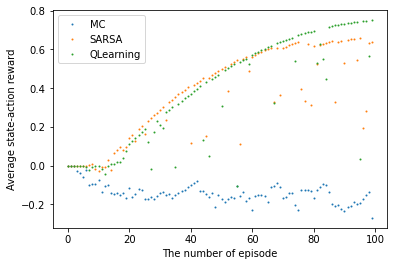

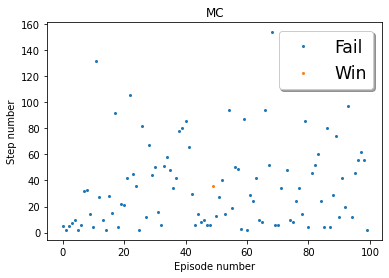

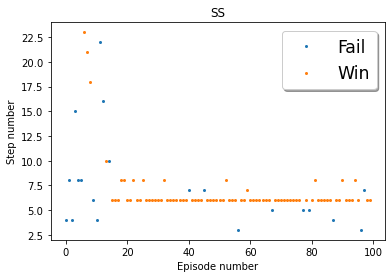

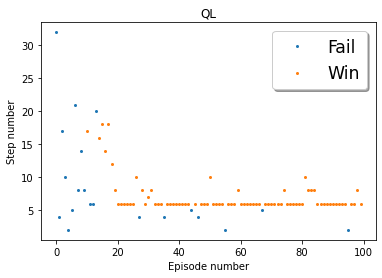

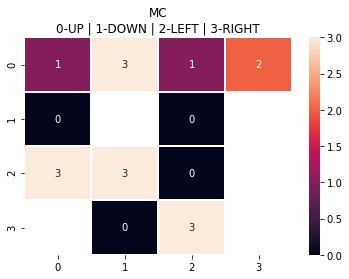

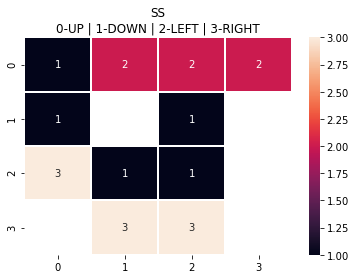

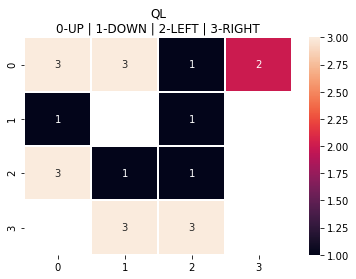

In [8]:
# set parameters
grid = (4,4)
start = (0,0)
wins = [(3,3)]
fails = [(1,1), (1,3), (2,3), (3,0)]
lr = 0.1 # learning rate
dr = 0.9 # discount rate
eps = 0.1 # epsilon
iteration = 100


# create "fl" class
# MC
mc1=fl(grid=grid, start=start, wins=wins, fails=fails, lr=lr, dr=dr, eps=eps)
# SS
ss1=fl(grid=grid, start=start, wins=wins, fails=fails, lr=lr, dr=dr, eps=eps)
# QL
ql1=fl(grid=grid, start=start, wins=wins, fails=fails, lr=lr, dr=dr, eps=eps)


# learning
mc1.learning("MC", iteration)
ss1.learning("SS", iteration)
ql1.learning("QL", iteration)


# plotting
# line plot
lplot(mc=mc1.epi_values, ss=ss1.epi_values, ql=ql1.epi_values)
# point plot
pplot(mc1.epi_infos, mc1.algo)
pplot(ss1.epi_infos, ss1.algo)
pplot(ql1.epi_infos, ql1.algo)
# heatmap
show_heatmap(mc1.Q, mc1.algo)
show_heatmap(ss1.Q, ss1.algo)
show_heatmap(ql1.Q, ql1.algo)

# 2. Extended implementation 10x10

Episode: 99
Step: 16
----------
OO88OOOOOO
OOO*8OO88O
OOOOOOOOOO
OO8OOOO8O8
8O8OOOO8OO
88OOOOOOOO
8OOOOOOOOO
888OOO8O88
8OOOOOOOOO
OO88OO88O1
----------


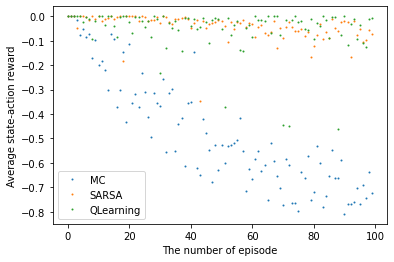

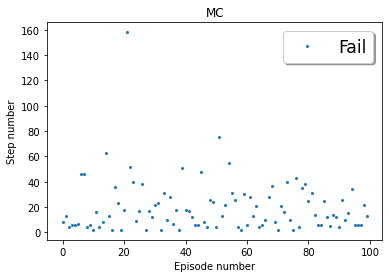

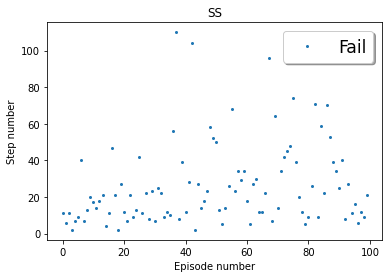

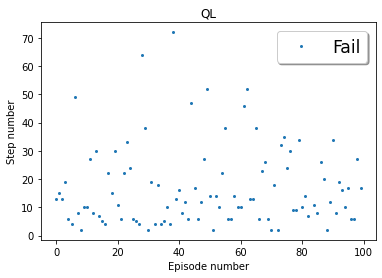

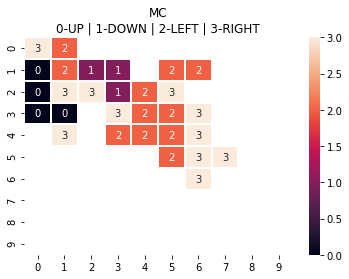

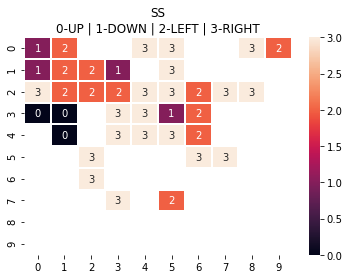

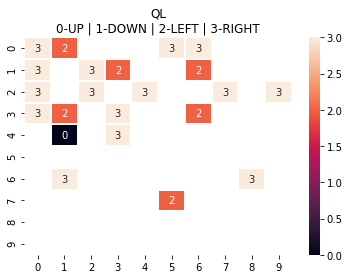

In [9]:
# set parameters
grid = (10,10)
start = (0,0)
wins = [(9,9)]
fails = None
# fails = [(9,5),(9,2),(9,0),(8,3),(8,1),(7,1),(6,9),(6,1),(5,8),(5,6),(5,0),(4,9),(4,8),(4,7),(4,0),(3,1),(3,0),(2,8),(2,5),(2,2),(1,8),(1,1),(0,8),(0,7),(0,5)]
hole_rate = 0.25
lr = 0.1 # learning rate
dr = 0.99 # discount rate
eps = 0.4 # epsilon
iteration = 100


# create "fl" class
# MC
mc2=fl(grid=grid, start=start, wins=wins, fails=fails, lr=lr, dr=dr, eps=eps, hole_rate=hole_rate)
if fails == None:
    mc2.get_grid() # create a random map if 'fails' is None
    fails = mc2.fails # save the map for comparison
# SS
ss2=fl(grid=grid, start=start, wins=wins, fails=fails, lr=lr, dr=dr, eps=eps, hole_rate=hole_rate)
# QL
ql2=fl(grid=grid, start=start, wins=wins, fails=fails, lr=lr, dr=dr, eps=eps, hole_rate=hole_rate)


# learning
mc2.learning("MC", iteration)
ss2.learning("SS", iteration)
ql2.learning("QL", iteration)


# plotting
# line plot
lplot(mc=mc2.epi_values, ss=ss2.epi_values, ql=ql2.epi_values)
# point plot
pplot(mc2.epi_infos, mc2.algo)
pplot(ss2.epi_infos, ss2.algo)
pplot(ql2.epi_infos, ql2.algo)
# heatmap
show_heatmap(mc2.Q, mc2.algo)
show_heatmap(ss2.Q, ss2.algo)
show_heatmap(ql2.Q, ql2.algo)